In [1]:
# tokenization library
!pip install tiktoken==0.8.0

In [2]:
import tiktoken
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pickle
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
# user llm library functions
from gpt import GPTModel, generate_text_simple
from dataloader import create_dataloader_v1
from ft_classification import (random_split,calc_accuracy_loader, calc_loss_batch, 
        evaluate_model, train_classifier_simple, plot_values, classify_review )
from pretraining import load_weights_into_gpt, text_to_token_ids, token_ids_to_text

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


### Initialize Model and Load Weights

In [3]:
GPT_CONFIG_355M = {
    "vocab_size": 50257,     # Vocabulary Size
    "context_length": 256,  # Context length
    "emb_dim": 1024,          # Embedding dimension
    "n_heads": 16,           # Number of attention heads
    "n_layers": 24,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [4]:
#initialize model
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_355M)
model.eval()

#load_weights in pytorch format
param_keys = [
    "blocks",
    "b",
    "g",
    "wpe",
    "wte"
]

params = {}
# Load (deserialize)
for weight in param_keys:
    with open("weights/"+weight+".pkl", "rb") as f:
        params[weight] = pickle.load(f)

In [5]:
#load pretrained weights
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-small (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-medium (355M)"
NEW_CONFIG = GPT_CONFIG_355M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length":1024})
NEW_CONFIG.update({"qkv_bias": True})

In [6]:
tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

### Data Loading and Preparation

In [7]:
with open("../data/full_feature_data.csv","r") as f:
    datalist = f.readlines()

In [8]:
featurelist = (datalist[0].replace('_', ' ').replace('num', 'number of')
               .replace('avg', 'average').replace('7d', ' 7 days,')
               .replace('30d', ' 30 days,').replace('90d', ' 90 days,')
               .replace('events week', 'events per week').split(','))
print(featurelist)

['userId', 'user churned', 'average events per weekend', 'average events per weekday', 'number of songs played  7 days', '', 'number of ads  7 days', '', 'number of error  7 days', '', 'number of songs played  30 days', '', 'number of songs played  90 days', '', 'number of sessions', 'average time per session', 'average events per session', 'average gap between session', 'number of events', 'number of songs', 'number of artists', 'number of thumbs down', 'number of thumbs up', 'number of add to playlist', 'number of ads', 'number of add friend', 'number of downgrade', 'number of upgrade', 'number of error', 'percentage ad', 'days since active', 'repeats ratio\n']


In [9]:
input_dict = {}
output_dict = {}
pos_label = "the user churned."
neg_label = "the user did not churn."
for j in range(9): #blow up data x 4 = 1720 <- balanced examples 
    # X 8 = 
    print(j, len(input_dict))
    for datarow in datalist[1:]:
        features = datarow.split(',')
        input_value = ''
        xs = list(range(len(features[2:])))
        random.shuffle(xs)         # xs is now shuffled
        for i in xs:
        #for i in range(len(features[2:])):
            input_value += featurelist[2 + i] + ' is ' + features[2+i] + ". "
        input_dict[str(j)+features[0]] = input_value
        output_dict[str(j)+features[0]] = (pos_label if features[1] == "1"
                                else neg_label
                                )
        
df = pd.DataFrame(list(zip(input_dict.values(), output_dict.values())), 
                  columns=['input_text', 'Label'])

0 0
1 1014
2 2028
3 3042
4 4056
5 5070
6 6084
7 7098
8 8112


In [10]:
len(df)

9126

In [11]:
print(df["Label"].value_counts())

Label
the user did not churn.    6030
the user churned.          3096
Name: count, dtype: int64


In [12]:
def create_balanced_dataset(df):
    # todo: take out hard-coding of target names and values
    num_pos = df[df["Label"] == pos_label].shape[0]
    neg_set = df[df["Label"] == neg_label].sample(
        num_pos, random_state=123
    )
    balanced_df = pd.concat([
        neg_set, df[df["Label"] == pos_label]
    ])
    return balanced_df

In [13]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
the user did not churn.    3096
the user churned.          3096
Name: count, dtype: int64


In [14]:
balanced_df["Label"] = balanced_df["Label"].map({neg_label: 0, pos_label: 1})

In [15]:
balanced_df

,input_text,Label
795,is 8640. number of artists is 146. number of ...,0
6837,average events per session is 25. average even...,0
4112,is 1424. number of songs played 90 days is 4...,0
1219,number of sessions is 3210. number of add frie...,0
8074,number of songs played 7 days is 7189. number...,0
...,...,...
9110,number of events is 63. is 2191. number of se...,1
9111,is 11. is 177. number of songs played 90 da...,1
9115,is 13. is 19. is 1646. average events per s...,1
9116,number of downgrade is 0.1824966078697422\n. n...,1


In [16]:
def random_split(df, train_frac, validation_frac):

    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df


In [17]:
train_df, validation_df, test_df= random_split(
    balanced_df, 0.7, 0.1)

In [18]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [19]:
class ChurnDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["input_text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [
            encoded_text + [pad_token_id] *
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return(
                torch.tensor(encoded, dtype=torch.long),
                torch.tensor(label, dtype=torch.long)
            )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [20]:
train_dataset = ChurnDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)
print("train max length:", train_dataset.max_length)
val_dataset = ChurnDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = ChurnDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

train length: 237


In [21]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions:", target_batch.shape)

Input batch dimensions: torch.Size([8, 237])
Label batch dimensions: torch.Size([8])


In [22]:
for param in model.parameters():
    param.requires_grad = False

In [23]:
CHOOSE_MODEL = "gpt2-medium (355M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length" : 1024,
    "drop_rate" : 0.0,
    "qkv_bias" : True
}
model_configs = {
    "gpt2-small (124M)" : {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)" : {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)" : {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)" : {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [24]:
for param in model.parameters():
    param.requires_grad = False

In [25]:
torch.manual_seed(123)
num_classes = 2
model.out_head= torch.nn.Linear(
    in_features = BASE_CONFIG["emb_dim"],
    out_features = num_classes
)

In [26]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [27]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [28]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs
 tensor([[[ 0.5492, -0.3534],
         [ 0.5739,  0.0416],
         [-0.1189,  1.0982],
         [-0.3349, -0.6146]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [29]:
print("Last output token:",  outputs[:, -1, :])

Last output token: tensor([[-0.3349, -0.6146]])


In [30]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
print(probas)
label = torch.argmax(probas)
print(label)
#print("Class label:", label)

tensor([[0.5695, 0.4305]])
tensor(0)


In [31]:
logits = outputs[:, -1, :]
print(logits)
label = torch.argmax(logits)
print("Class label:", label.item())

tensor([[-0.3349, -0.6146]])
Class label: 0


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else cpu())
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(256, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=False)
        (W_key): Linear(in_features=1024, out_features=1024, bias=False)
        (W_value): Linear(in_features=1024, out_features=1024, bias=False)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear

In [33]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 55.00%
Validation accuracy: 48.75%
Test accuracy: 51.25%


In [34]:
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 8
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
    )
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed n {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.785, Val loss 0.715, 
Ep 1 (Step 000050): Train loss 0.729, Val loss 0.685, 
Ep 1 (Step 000100): Train loss 0.698, Val loss 0.681, 
Ep 1 (Step 000150): Train loss 0.687, Val loss 0.670, 
Ep 1 (Step 000200): Train loss 0.702, Val loss 0.707, 
Ep 1 (Step 000250): Train loss 0.677, Val loss 0.691, 
Ep 1 (Step 000300): Train loss 0.671, Val loss 0.683, 
Ep 1 (Step 000350): Train loss 0.695, Val loss 0.674, 
Ep 1 (Step 000400): Train loss 0.820, Val loss 0.726, 
Ep 1 (Step 000450): Train loss 0.687, Val loss 0.677, 
Ep 1 (Step 000500): Train loss 0.694, Val loss 0.685, 
Training accuracy: 55.00% | Validation accuracy: 60.00%
Ep 2 (Step 000550): Train loss 0.686, Val loss 0.672, 
Ep 2 (Step 000600): Train loss 0.638, Val loss 0.654, 
Ep 2 (Step 000650): Train loss 0.678, Val loss 0.738, 
Ep 2 (Step 000700): Train loss 0.647, Val loss 0.685, 
Ep 2 (Step 000750): Train loss 0.900, Val loss 0.820, 
Ep 2 (Step 000800): Train loss 0.670, Val loss 0.690, 
Ep 2 (Ste

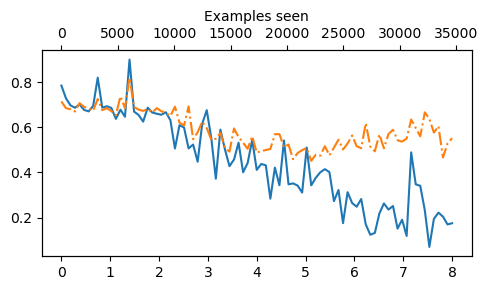

In [35]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

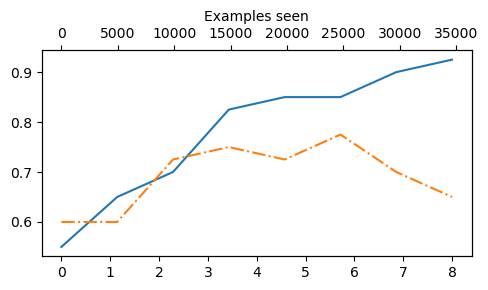

In [36]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

In [37]:
train_accuracy = calc_accuracy_loader(
    train_loader, model, device)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 93.00%
Validation accuracy: 72.40%
Test accuracy: 72.32%
